# Analyse des causes des incendies

## Problématique
**Quels types de causes sont les plus fréquemment associées aux incendies, et comment influencent-elles l'étendue des dégâts ?**

Les données utilisées proviennent de la Base de Données sur les Incendies de Forêts en France, pour l'année 2023.

## Hypothèses
1. Les causes humaines (négligence, activités humaines) sont majoritaires et mènent généralement à des incendies de plus grandes tailles.
2. Les causes naturelles (foudre, conditions climatiques) sont moins fréquentes mais entraînent souvent des incendies de plus petite ampleur.

## Préparation des données

Nous allons :
- Nettoyer et organiser les données pour analyser les causes.
- Identifier les différentes catégories de causes d'incendies.

In [8]:
# Import des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('incendies_2023.csv', delimiter=';')

# Nettoyage des colonnes pertinentes
data['Surface parcourue (m2)'] = pd.to_numeric(data['Surface parcourue (m2)'], errors='coerce')
data['Nature'] = data['Nature'].fillna('Inconnue')

# Aperçu des données
data[['Nature', 'Surface parcourue (m2)']].head()

,Nature,Surface parcourue (m2)
0,Malveillance,100
1,Inconnue,2
2,Accidentelle,1000
3,Inconnue,10000
4,Involontaire (particulier),35


## Distribution des causes

Analysons la répartition des causes des incendies.

C:\Users\mluporsi\AppData\Local\Temp\ipykernel_36824\1685516910.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cause_counts.index, y=cause_counts.values, palette='viridis')


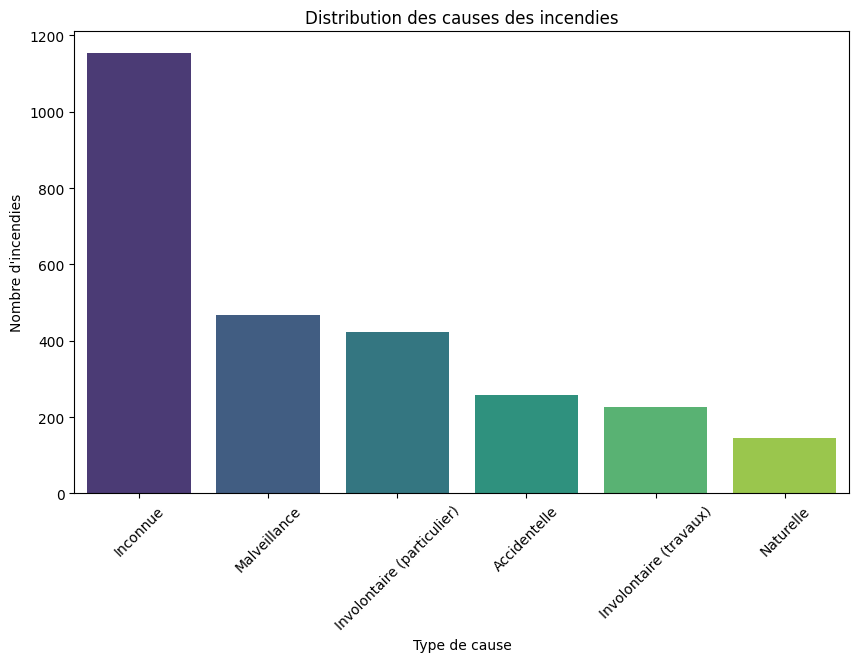

In [4]:
# Distribution des causes
cause_counts = data['Nature'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cause_counts.index, y=cause_counts.values, palette='viridis')
plt.title('Distribution des causes des incendies')
plt.xlabel('Type de cause')
plt.ylabel('Nombre d\'incendies')
plt.xticks(rotation=45)
plt.show()

On remarque que la cause de la plupart des incendies ne sont pas connue, ce qui est compréhensible.

On voit aussi que les incendies causé par l'homme et son activité sont largement majoritaire.

## Impact des causes sur les surfaces parcourues

Étudions comment les différentes causes influencent la taille des incendies.

C:\Users\mluporsi\AppData\Local\Temp\ipykernel_36824\1298195802.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=surface_by_cause.index, y=surface_by_cause.values, palette='viridis')


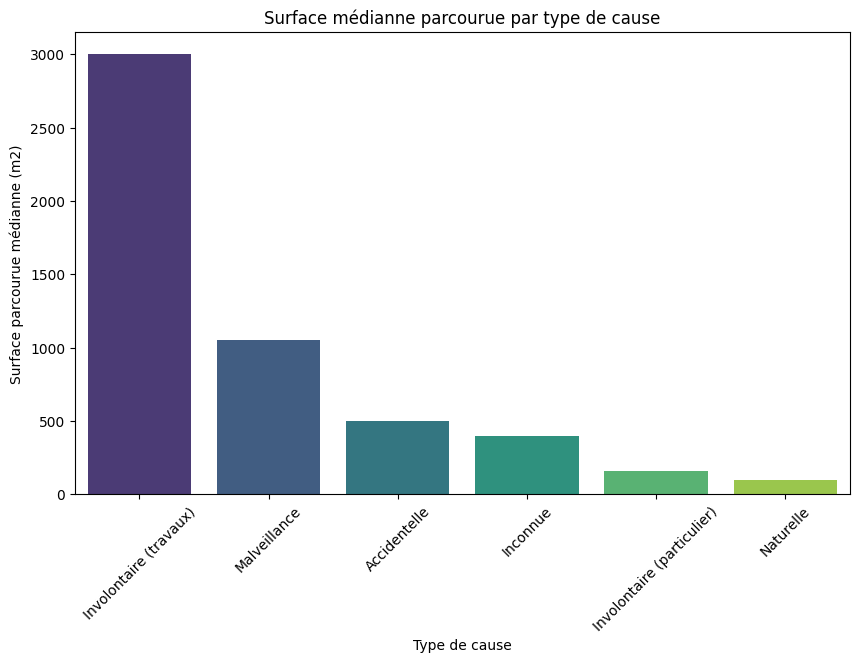

In [13]:
# Analyse des surfaces parcourues par cause
surface_by_cause = data.groupby('Nature')['Surface parcourue (m2)'].median()
surface_by_cause = surface_by_cause.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=surface_by_cause.index, y=surface_by_cause.values, palette='viridis')
plt.title('Surface médianne parcourue par type de cause')
plt.xlabel('Type de cause')
plt.ylabel('Surface parcourue médianne (m2)')
plt.xticks(rotation=45)
plt.show()

Les incendies malveillants et involontaires (travaux) sont les plus ravageurs en termes de surface parcourue.

Les causes naturelles sont moins destructrices.

## Analyse départemental des causes

Identifions les causes prédominantes par département.

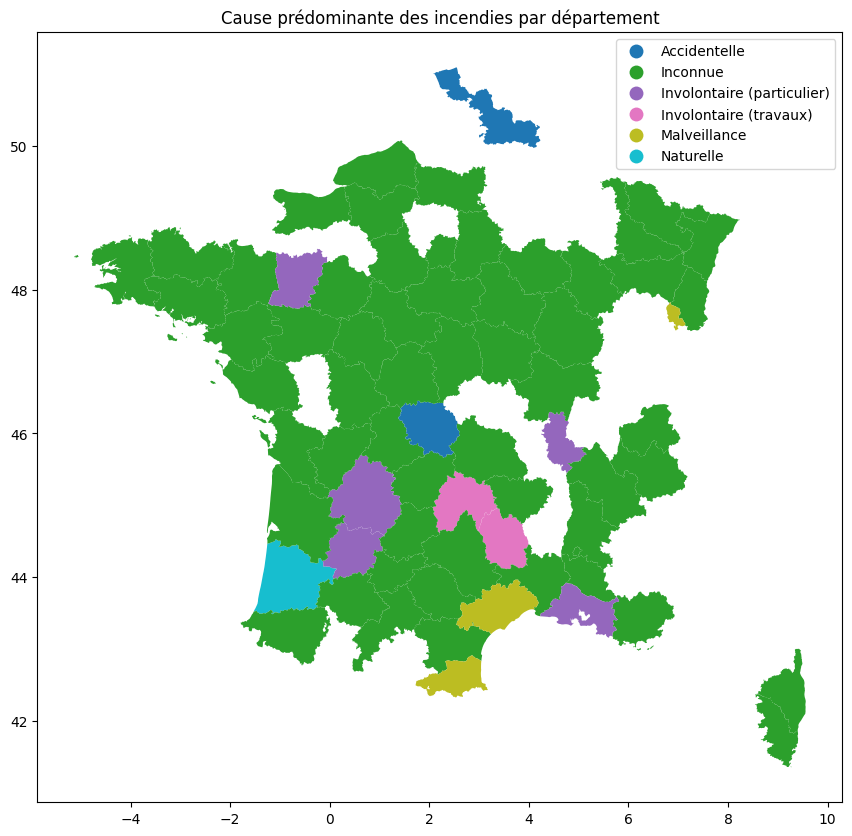

In [ ]:
import geopandas as gpd

# Charger les données géographiques (GeoJSON des departements françaises)
departements = gpd.read_file('departements.geojson')

# Calculer la cause prédominante par région
predominant_cause_by_region = data.groupby('Département')['Nature'].agg(lambda x: x.value_counts().idxmax())

# Fusionner les données géographiques avec les causes prédominantes
departements['PredominantCause'] = departements['code'].map(predominant_cause_by_region)

# Afficher la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
departements.plot(column='PredominantCause', ax=ax, legend=True, legend_kwds={'loc': 'upper right'})
plt.title('Cause prédominante des incendies par département')
plt.show()


## Exploration des incendies majeurs

Analysons les incendies ayant parcouru les plus grandes surfaces.

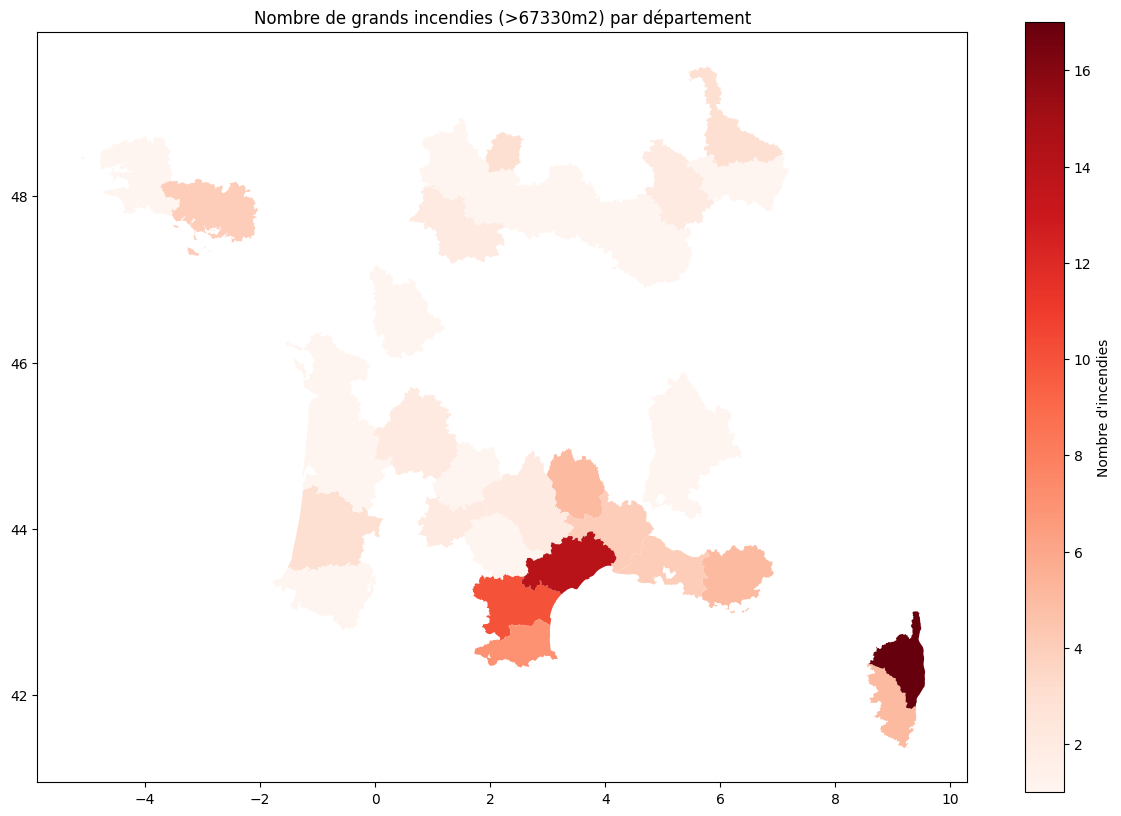

In [29]:
# Définir un seuil pour les grands incendies
threshold = data['Surface parcourue (m2)'].quantile(0.95)

# compter les grands incendies par département
big_fires = data[data['Surface parcourue (m2)'] > threshold]['Département'].value_counts()

# Fusionner les données géographiques avec les grands incendies
departements['BigFires'] = departements['code'].map(big_fires)

# Afficher la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
departements.plot(column='BigFires', ax=ax, legend=True, legend_kwds={'label': "Nombre d'incendies"}, cmap='Reds')
plt.title(f'Nombre de grands incendies (>{int(threshold)}m2) par département')
plt.show()

## Exploration de la corrélatation entre la cause et la surface touché

Analysons si le type d'incendie influe sur la surface touché ou non

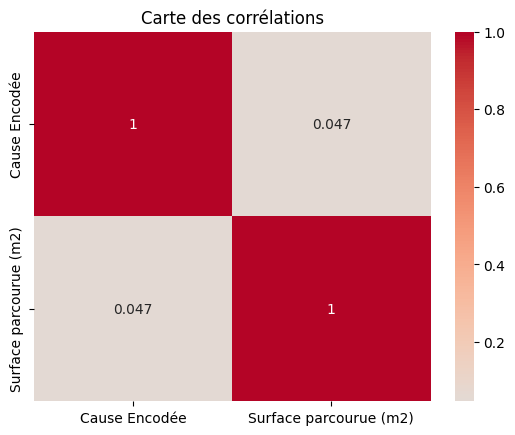

In [32]:
# Encodage des causes pour calculer la corrélation
cause_mapping = {
    'Accidentelle': 1,
    'Inconnue': 0,
    'Involontaire (particulier)': 2,
    'Involontaire (travaux)': 3,
    'Malveillance': 4,
    'Naturelle': 5
}

data['Cause Encodée'] = data['Nature'].map(cause_mapping)

# Corrélation entre les causes encodées et la surface parcourue
correlation = data[['Cause Encodée', 'Surface parcourue (m2)']].corr()

# Visualisation de la corrélation
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Carte des corrélations')
plt.show()


Cette corrélation faible peut signifier que les causes des incendies (accidentelle, naturelle, etc.) n'influencent pas directement la surface parcourue.

D'autres facteurs (comme les conditions météorologiques, la végétation, ou les délais d'intervention) pourraient jouer un rôle plus important.

## Autres pistes

Cherchons quels facteurs pourrais donc grandement influer sur la taille des incendies

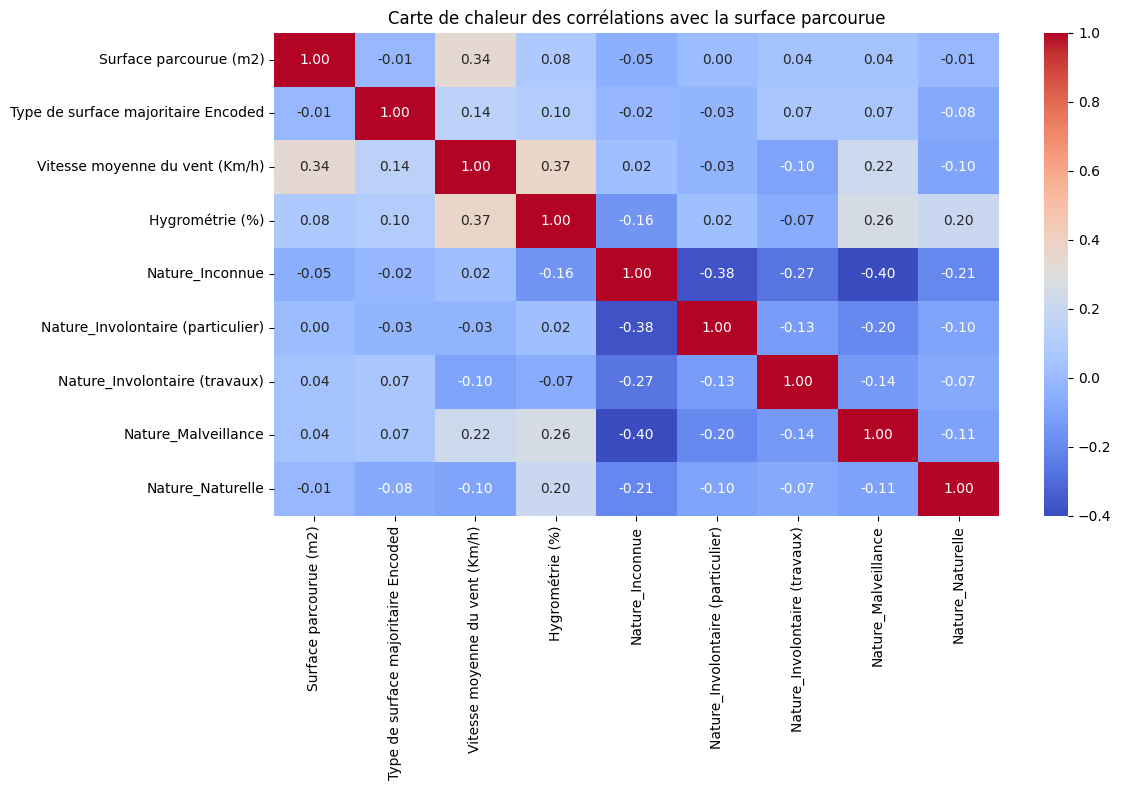

In [35]:
# Identifier la surface majoritaire pour chaque ligne
surface_columns = [
    'Surface forêt (m2)',
    'Surface maquis garrigues (m2)',
    'Surfaces agricoles (m2)',
    'Autres surfaces naturelles hors forêt (m2)',
    'Autres surfaces (m2)'
]

# Trouver la colonne avec la valeur maximale
data['Type de surface majoritaire'] = data[surface_columns].idxmax(axis=1)

# Encodage de la surface majoritaire
data['Type de surface majoritaire Encoded'] = data['Type de surface majoritaire'].astype('category').cat.codes

# Choix des colonnes pour la corrélation
correlation_columns = [
    'Surface parcourue (m2)',
    'Type de surface majoritaire Encoded',
    'Vitesse moyenne du vent (Km/h)',
    'Hygrométrie (%)',
    'Température (°C)',
    'Nature'
]

# Encodage des variables catégorielles
encoded_nature = pd.get_dummies(data['Nature'], prefix='Nature', drop_first=True)

# Concaténation des données
correlation_data = pd.concat([data[correlation_columns[:4]], encoded_nature], axis=1)

# Calcul de la matrice de corrélation
correlation_matrix = correlation_data.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Carte de chaleur des corrélations avec la surface parcourue")
plt.tight_layout()
plt.show()


Facteurs météorologiques :
- La vitesse moyenne du vent a une corrélation modérée avec la surface parcourue (0.34).
- L'hygrométrie a une faible corrélation positive (0.08).

Type de surface majoritaire :
- Le type de surface majoritaire encodé montre une très faible corrélation avec la surface parcourue (-0.01), ce qui pourrait indiquer que le type de surface seul n'explique pas directement l'étendue des incendies.

Nature de l'incendie :
- Les incendies par malveillance montrent une corrélation modérée avec la surface parcourue (0.04). On pourrait imaginier que de part leur nature à faire du dégat, la surface touché est plus grande. Les autres types montrent des relations très faibles.


Connaissance de la cause :
- Les incendies avec une cause inconnue ont une légère corrélation négative (-0.05) avec la surface parcourue, probablement en raison de données limitées ou imprécises.

## Conclusion

L'analyse des données révèle des corrélations faibles à modérées entre les facteurs étudiés et la surface parcourue par les incendies. Parmi les facteurs météorologiques, la vitesse moyenne du vent joue un rôle significatif, avec une corrélation modérée (0.34), tandis que d'autres variables, comme l'hygrométrie ou la température, montrent des impacts limités. Les types de surface n'expliquent pas directement l'étendue des incendies, suggérant que d'autres facteurs contextuels pourraient être en jeu.

La nature des incendies, notamment ceux dus à la malveillance, présente une légère influence, mais les causes inconnues limitent la précision des conclusions. Ces résultats mettent en lumière la complexité des dynamiques des incendies.

Cette analyse pourrait être approfondie en explorant des modèles prédictifs pour mieux anticiper la propagation des incendies.